<a href="https://colab.research.google.com/github/karencfisher/face_express/blob/main/notebooks/conv_model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The initial dataset is from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The ```icml_face_data.csv``` (AKA ```fer2013```) dataset which contains a total of 34034 samples. It contains 3 columns. The target label is an integer (0, 6), the eight basic emtions:

```
['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
```

The labels are updated to 8 basic categories based on crowd sourcing by a group of researchers at Microsoft Research perceiving that the original fer2013 dataset had wildly inaccurate labels. Often facial expressions, by even human performance, can be ambiguous. They had 10 labellers vote on 8 basic emotions (omitting 'unkown'):

```
['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']
```

One strategy to then use this data is to use the 'majority rule', as followed here.

The images are stored in the 'pixels' column, as a string of 2304 integer values (0, 255) separated by spaces. These will need be coverted into an array of integer values. Subsequently, they will be needs reshaped into 3-d numpy arrays to be input to the CNN.



In [3]:
def loadCleanData(fname):
    df = pd.read_csv(fname)
    
    # regularize capitalization and remove leading space in column headings
    fix_cols = {s : s.lower().strip() for s in df.columns.to_list()}
    df.rename(columns = fix_cols, inplace=True)
    
    # convert pixels from strings to lists of integers
    df['pixels'] = df['pixels'].apply(lambda x: [int(i) for i in x.split()])
    
    return df

In [4]:
df = loadCleanData('/content/drive/MyDrive/face express data/icml_face_data.csv')
df.head()

,emotion,usage,pixels
0,0,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [5]:
df_labels = pd.read_csv('https://raw.githubusercontent.com/microsoft/FERPlus/master/fer2013new.csv')
df_labels.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


In [6]:
df_labels = df_labels[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']]
fer2013_new = pd.concat([df, df_labels], axis=1)

The ```fer2013_new``` label set however has a number of missing values (NF or 'No File' == 10). As these samples (176 examples, 0.5% of the data) were then dropped from the dataset. We then disregard the NF column and 'unknown' columns.

In [7]:
fer2013_new.head()

,emotion,usage,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,0,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",4,0,0,1,3,2,0,0,0,0
1,0,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",6,0,1,1,0,0,0,0,2,0
2,2,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",5,0,0,3,1,0,0,0,1,0
3,4,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",4,0,0,4,1,0,0,0,1,0
4,6,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",9,0,0,1,0,0,0,0,0,0


In [8]:
fer2013_new = fer2013_new[fer2013_new['NF'] < 10]
fer2013_new.shape

(35711, 13)

In [49]:
# Select all but NF for use
y = fer2013_new[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']].values

In [50]:
# Majority rule
def makeClasses(votes):
  probs = []
  for row in range(votes.shape[0]):
    y = np.argmax(votes[row])
    probs.append(y)

  return np.array(probs)


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

Split into training and testing sets.

In [52]:
x_train, x_test, y_train, y_test = train_test_split(fer2013_new['pixels'],
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((28568,), (7143,), (28568, 8), (7143, 8))

Normalize the image data to in range (0, 1). We will also first have to transform lists of integers to a 2-d numpy array, and then reshape that into the 4-d array (m, h, w, c) as neede by the convolutional layers.

In [53]:
# transform lists of integers into numpy arrays, and normalize the values
x_train = np.vstack(x_train) / 255
x_test = np.vstack(x_test) / 255

# reshape arrays into (m, h, w, c). As they are square, we can get the height
# and width values as a square root of the length the original 1-d array.
n = int(np.sqrt(x_train.shape[1]))
x_train = x_train.reshape(x_train.shape[0], n, n, 1)
x_test = x_test.reshape(x_test.shape[0], n, n, 1)

# Convert the pandas series of target classes to numpy array of majority cases
y_train = makeClasses(y_train)
y_test = makeClasses(y_test)

In [73]:
model = Sequential([Conv2D(64, (3, 3), input_shape=x_train.shape[1:], activation='relu'),
                    BatchNormalization(),
                    Conv2D(64, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPool2D((3, 3), strides=(2, 2)),
                    Dropout(0.3),
                    
                    Conv2D(128, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    Conv2D(128, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPool2D((3, 3), strides=(2, 2)),
                    Dropout(0.3),
                    
                    Conv2D(256, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    Conv2D(256, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPool2D((3, 3), strides=(2, 2)),
                    Dropout(0.3),
                    
                    Conv2D(512, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    Conv2D(512, (3, 3), padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPool2D((2, 2), strides=(2, 2)),
                    Dropout(0.3),
                    
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dropout(0.5),
                    Dense(256, activation='relu'),
                    Dropout(0.5),
                    Dense(64, activation='relu'),
                    Dropout(0.5),
                    Dense(8, activation='softmax')])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_48 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_49 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 22, 22, 128)      

Training the model. Employ also early stopping and model checkpoint

In [74]:
stop = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/face express data/weights.h5', 
                             monitor='val_acc', save_best_only=True, 
                             save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

history = model.fit(x_train,
          y_train,
          validation_data=(x_test, y_test),
          epochs=100,
          batch_size=128,
          callbacks=[stop, checkpoint, reduce_lr])

Epoch 1/100
224/224 [==============================] - 17s 76ms/step - loss: 1.9378 - acc: 0.3073 - val_loss: 1.6243 - val_acc: 0.3595
Epoch 2/100
224/224 [==============================] - 17s 76ms/step - loss: 1.6246 - acc: 0.3738 - val_loss: 1.6485 - val_acc: 0.3602
Epoch 3/100
224/224 [==============================] - 17s 76ms/step - loss: 1.4998 - acc: 0.4247 - val_loss: 1.4010 - val_acc: 0.4417
Epoch 4/100
224/224 [==============================] - 17s 76ms/step - loss: 1.3518 - acc: 0.5230 - val_loss: 1.3176 - val_acc: 0.5492
Epoch 5/100
224/224 [==============================] - 17s 75ms/step - loss: 1.1706 - acc: 0.6140 - val_loss: 1.2725 - val_acc: 0.5862
Epoch 6/100
224/224 [==============================] - 17s 75ms/step - loss: 1.0599 - acc: 0.6588 - val_loss: 1.0680 - val_acc: 0.6259
Epoch 7/100
224/224 [==============================] - 17s 75ms/step - loss: 0.9926 - acc: 0.6783 - val_loss: 1.0906 - val_acc: 0.6381
Epoch 8/100
224/224 [==============================] - 

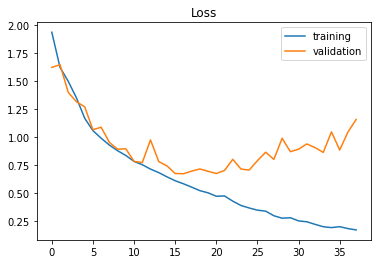

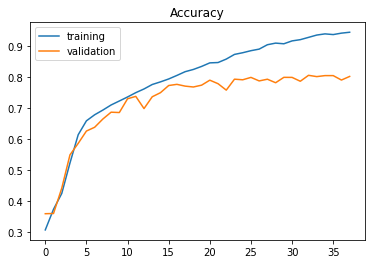

In [75]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

In [76]:
model.save('/content/drive/MyDrive/face express data/model2.h5')

Alternatively, load a model that has been trained and saved.

In [77]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/face express data/model2.h5')


In [78]:
preds = model.predict(x_test)
y_pred = [np.argmax(pred) for pred in preds]
score = accuracy_score(y_test, y_pred)
print(f'Accuracy = {round(score * 100, 2)} %')

Accuracy = 80.55 %


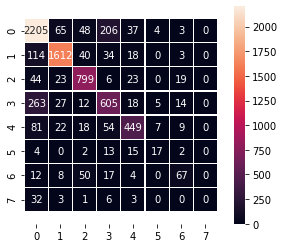

In [79]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', linewidths=.2, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

{'neutral': 2568, 'happiness': 1821, 'surprise': 914, 'sadness': 944, 'anger': 640, 'disgust': 53, 'fear': 158, 'contempt': 45}


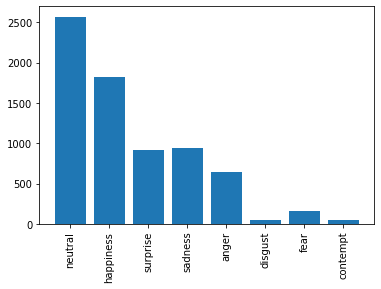

In [80]:
classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']

y_count = np.bincount(y_test)
labels = {classes[i]: y_count[i] for i in range(len(classes))}
print(labels)
plt.bar(classes, y_count)
plt.xticks(rotation=90);

Perform inference on a random selected sample from the test dataset

In [63]:
def tryRandomExample():
    index = np.random.randint(0, x_test.shape[0])
    img = x_test[index]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    best = np.argmax(pred[0])
    
    print(classes[best] == classes[y_test[index]])
    print(f'Predicted label: {classes[best]}\nConfidence: {round(pred[0][best] * 100, 2)} %')
    print(f'Actual label: {classes[y_test[index]]}')
    
    plt.imshow(np.squeeze(img[0], axis=-1), cmap='gray')
    plt.show()
    
    df = pd.DataFrame(dict(probs=list(pred[0]), labels=classes))
    fig = px.line_polar(df, r='probs', theta='labels', line_close=True)
    fig.show()
    
    

True
Predicted label: happiness
Confidence: 100.0 %
Actual label: happiness


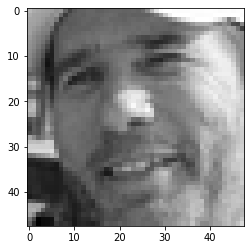

In [91]:
tryRandomExample()